In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

C:\Users\sanya\AppData\Local\Temp\ipykernel_70276\3227033813.py:11: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [30]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


def pt_d_sample_test(data1, data2, c=1, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    old_expressions = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=max(max_depth, old_expressions))

    if max_depth < 0:
        max_depth = max(1, int(np.floor(np.log2(len(data1)) / 2)))

    # Combine datasets and create a group identifier
    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])
    X = data[:, 0]  # assign the scaled value to X

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    discrete_values = np.unique(binary)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    n_hypotheses = len(discrete_values)
    logbf = p_H0 - p_H1 + np.log(n_hypotheses)
    np.set_printoptions(threshold=old_expressions)

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf


def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]  # counts the number of data in each interval (2 vector).
    else:
        n_j = [
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1]))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1])))
        ]  # 4 vector 

    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  # log of beta function
    else:
        logl = lmbeta(n_j[0] + a_j, n_j[1] + a_j, n_j[2] + a_j, n_j[3] + a_j) - lmbeta(a_j, a_j, a_j, a_j)

    if isinstance(low, (int, float)):
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions
    else:
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [low[0], (low[1] + up[1]) / 2], [(low[0] + up[0]) / 2, up[1]],
                                   c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [(low[0] + up[0]) / 2, low[1]], [up[0], (low[1] + up[1]) / 2],
                                   c, depth + 1, max_depth, qdist, aj)
        ]

    return logl + np.sum(likelihoods)


def lmbeta(*args):
    return np.sum(gammaln(args)) - gammaln(np.sum(args))


def is_discrete(X):
    return np.all(np.isin(X, np.arange(11)))  # evaluates to TRUE only if every element of X lies within the specified range of 0 to 10.


def scale(data):
    return (data - np.mean(data)) / np.std(data)


In [2]:
sukh_param=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')

In [3]:
sukh_param

[{'progenitor_mass': <Quantity 27. solMass>, 'eos': 'LS220'}]

In [4]:
model_a = {'name': 'Sukhbold_2015',
            'param': sukh_param[0]
              }

In [7]:
labels=['normal','nmo','imo']
norms=[]
nmos=[]
imos=[]
sims=[norms,nmos,imos]
for i in range(100):
    sim_i = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='inverted')


    sim = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s, tmax=10*u.s, dt=1*u.ms,
                     )


    sim_n = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s,tmax=10*u.s, dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='normal')
    sim.run()
    sim_i.run()
    sim_n.run()
    for j,simm in enumerate([sim, sim_n,sim_i]): 
        with open("Sukhbold_eos={}_M={}_mix={}_num={}.pkl".format(sukh_param[0]['eos'], 
                                                                 sukh_param[0]['progenitor_mass'].value,
                                                                 labels[j], i), 'wb') as f:
            pickle.dump(simm, f)
        sims[j].append(simm)

In [7]:
labels=['normal','nmo','imo']
norms=[]
nmos=[]
imos=[]
sims=[norms,nmos,imos]

for i in range(100):
    for j,lab in enumerate(labels): 
        with open("Sukhbold_eos={}_M={}_mix={}_num={}.pkl".format(sukh_param[0]['eos'], 
                                                                 sukh_param[0]['progenitor_mass'].value,
                                                                 labels[j], i), 'rb') as f:
            mod=pickle.load(f)
        sims[j].append(mod)

Text(0.5, 1.0, 'Detector Signal for 100 Simulations, Sukhbold with M=27 and EOS=LS220')

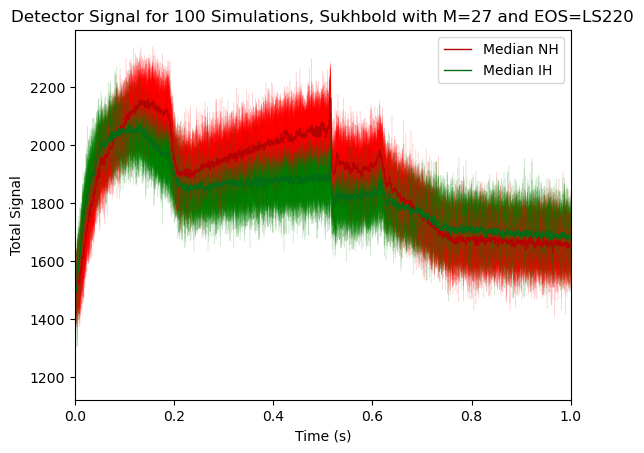

In [45]:
dt = 1 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(1,3):
        simm=sims[j][i]
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        hits_tot[j-1].append(hits+bg)
        plt.step(t, hits+bg, where='post',lw=.2,color=colors[j],alpha=.3)

med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)
plt.step(t,med_nh,where='post',lw=1,color='#b50202',label='Median NH')
plt.step(t,med_ih,where='post',lw=1,color='#016b16',label='Median IH')

plt.legend()
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Detector Signal for 100 Simulations, Sukhbold with M=27 and EOS=LS220')

**BAYES FACTOR**

In [44]:
bfs=[]
dt = 1 * u.ms

for i in range(100):
    for j in range(100):
        simm_nh=sims[1][i]
        simm_nh.rebin_result(dt)
        
        t, hits1 = simm_nh.detector_signal(dt)
        bg1 = simm_nh.detector.i3_bg(dt, size=hits1.size) + simm_nh.detector.dc_bg(dt, size=hits1.size)
        sig1=bg1+hits1
        mean_under1=np.mean(np.append(sig1[5000:9000],sig1[14000:18000]))
        data1=np.subtract(sig1,mean_under1)[9900:15000]
        
        
        simm_ih=sims[2][j]
        simm_ih.rebin_result(dt)
        t, hits2 = simm_ih.detector_signal(dt)
        bg2 = simm_ih.detector.i3_bg(dt, size=hits2.size) + simm_ih.detector.dc_bg(dt, size=hits2.size)
        sig2=bg2+hits2
        mean_under2=np.mean(np.append(sig2[5000:9000],sig2[14000:18000]))
        data2=np.subtract(sig2,mean_under2)[9900:15000]
        
        log_bf = pt_d_sample_test(data1, data2, log_BF=True)
        bfs.append(log_bf)
        

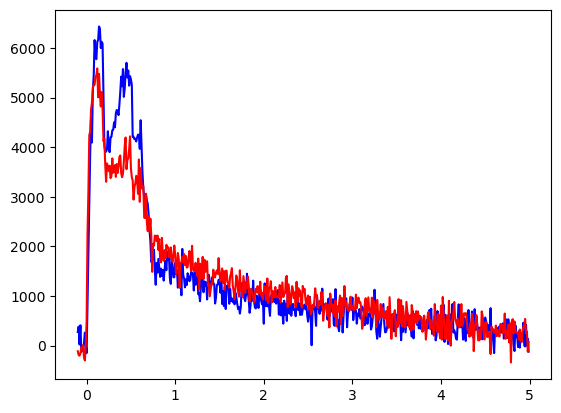

In [40]:
simm_nh=sims[1][0]
simm_nh.rebin_result(dt)
        
t, hits1 = simm_nh.detector_signal(dt)
bg1 = simm_nh.detector.i3_bg(dt, size=hits.size) + simm_nh.detector.dc_bg(dt, size=hits.size)
sig1=bg1+hits1
mean_under1=np.mean(np.append(sig1[500:900],sig1[1400:1800]))
data1=np.subtract(sig1,mean_under1)[990:1500]
        
        
simm_ih=sims[2][0]
simm_ih.rebin_result(dt)
t, hits2 = simm_ih.detector_signal(dt)
bg2 = simm_ih.detector.i3_bg(dt, size=hits.size) + simm_ih.detector.dc_bg(dt, size=hits.size)
sig2=bg2+hits2
mean_under2=np.mean(np.append(sig2[500:900],sig2[1400:1800]))
data2=np.subtract(sig2,mean_under2)[990:1500]

plt.plot(t[990:1500],data1,color='blue')
plt.plot(t[990:1500],data2,color='red')

Text(0.5, 1.0, 'Bayes Factors Comparing 10,000 Combinations of NH and IH')

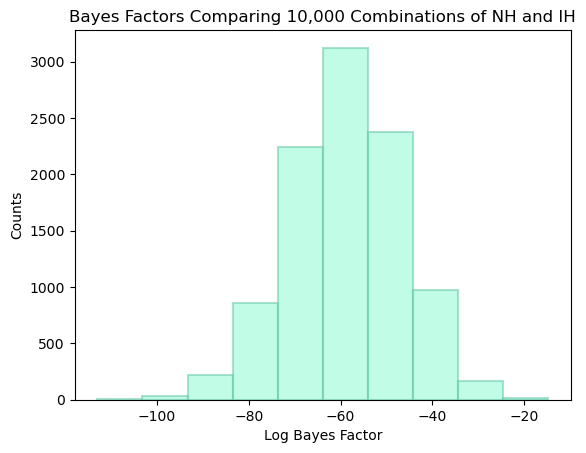

In [46]:
plt.hist(bfs, alpha=0.5, color='#84facf', edgecolor='#60c4a3', linewidth=1.5)
plt.xlabel('Log Bayes Factor')
plt.ylabel('Counts')
plt.title('Bayes Factors Comparing 10,000 Combinations of NH and IH')

**KS TEST**

In [47]:
dt = 1 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(1,3):
        simm=sims[j][i]
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=hits+bg
        mean_under=np.mean(np.append(sig[5000:9000],sig[14000:18000]))
        data=np.subtract(sig,mean_under)[9900:15000]
        hits_tot[j-1].append(data)
        
med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)



In [ ]:
ks_nh=[]
pval_nh=[]
for i in range(100):
    
sorted_sig=np.sort(cut_sig)
cdf_hits = np.arange(1, len(sorted_sig) + 1) / len(sorted_sig)
cdf_hits = np.arange(1, len(sorted_sig) + 1) / len(sorted_sig)
cdfs.append(sorted_sig)
        
statistic, p_value = stats.ks_2samp(cdfs[0], cdfs[1], alternative='two-sided', mode='auto')
p_vals.append(p_value)